# Notebook for extracting features for authorship attribution.
In this notebook all authorship attribution features will be collected. They will be saved after extraction. Make sure, you define each feature extraction in a function, so it easily can be repurposed.

Author: lkt259@alumni.ku.dk & vsl133@alumni.ku.dk

In [2]:
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from lexicalrichness import LexicalRichness
from matplotlib import pyplot as plt
import random
import spacy
import os, sys

In [5]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

#### Sentence length
Nice feature, very complex!

In [6]:
string = "We can work with single sentences (classifying them with respect to sentiment, topic, authorship, etc), or more than one at a time (checking for similarities, contradiction, question/answer pairs, etc.) Another successful application is to encode one sentence in one language and use a different autoencoder to decode it into another language, e.g. Cho et al. (2014)."
train_corpus = ['This list has overlapping features with content features. For example, word n-grams will capture the content of the text along with stylometric tendencies. Content features consist of word frequencies, word and character n-grams, hapax legomena etc. This overlap is not of concern, however, as Sari et al. \cite{Sari2018} show, using content features is beneficial when performing authorship attribution of news articles because journalists often have certain topics they prefer writing about. They argue that using only stylometric features is beneficial when attributing authors to texts of the same topic or genre, e.g. law text or movie reviews.',
              'Bozkurt et al. \cite{Bozkurt} performed authorship attribution on Turkish newspaper articles using stylometric features, vocabulary diversity, bag of words and frequency of function words. For stylometric features, they used number of sentences and words in the article, the average number of words in a sentence and the whole article, the vocabulary size, frequencies of symbols used (periods, exclamation marks, etc.) and the number of incomplete sentences. They weighted their features using Term Frequency-Inverse Document Frequency (TF-IDF).',
              'TF-IDF is a weighting system often used on words. It consists of two parts: term frequency (TF), which coulds how often a term occurs in a document, and inverse document frequency (IDF) which measures the term importance, as it compares how often the term occurs in a corpus\cite{TFIDF}. The system is useful for measuring how important a term is for a document. For example, the word "the" will often occur in English texts, making it not important even though it occurs frequently in a document. TF-IDF has on many occasions been used in authorship attribution\cite{Muttenhaler, basile:2019, rahgouy:2019} and can be used on different terms, such as characters, symbols or n-grams.',
              'Every year, the research group Webis hosts the PAN shared tasks on digital text forensics and sylometry\cite{PAN}. Contestants will solve various tasks concerning NLP and on multiple occasions, authorship attribution were part of the tasks. The methodologies used in these tasks are useful resources for feature and model selections.',
              'In the overview paper of the authorship attribution task of PAN 2019\cite{kestemont2019overview}, the 12 best performing models are compiled. All features involve character n-grams and other sorts of n-grams. Other popular choices of n-grams contain words, POS tags, punctuation and distortion. Most of the participants use TF-IDF weighting and SVMs as classifiers. Distortion is a method for masking topical contents of the text before feature extraction, focusing only on stylometric features.']
test_corpus = ['I have been unable to generate numbers by the Bohr hypothesis, but given more time, I would have simulated multiple distributions following the formula and compare the peak locations to my fit results, by looking at their means and if plausible, perform a t- or z-test to compare. Perhaps using a Kolmogorov-Smirnov test on the entirety of the data would show if it matches only by the peaks or by the whole distribution.',
               "In recent years there have been an increasing interest in biometric identification. Various studies has been conducted aiming to detect individual or unique demographic traits. Results from recent studies have given reason to believe that the ability to predict demographic information using eye tracking is highly dependent on the stimulus. Based on this, this study performs a comparison using two datasets built on different stimulus: IQ tests and passive image viewing. This study found significant differences in the accuracy achieved on the two datasets using a Random Forest (RF) and Long-Short Term Memory network (LSTM) as classifiers. The random forest performed best with an accuracy of 0.85 on the passive image viewing dataset and 0.70 on the IQ dataset. Furthermore, we investigated the effect of using micro movements of the eye as features in the model, which has proven to be a useful feature in recent studies within biometric identification. Lastly, we report the classifiers' ability to perform task independent predictions of gender, using one dataset for training and another for testing. The result from this experiments was not satisfying and close to chance level. However, combining the dataset for training and testing resulted in the random forest having an overall accuracy on the combined dataset of 0.74.",
              ]

In [3]:
def split_sentences(text):
    '''Returns an array with text split into sentences'''
    return np.array(re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text), dtype=str)

def remove_dots(word):
    return re.sub(r',|\.|:|!|\?|;', '', word)

def split_words(text):
    '''Returns an array with text split into words'''
    text = text.lower()
    string = np.array(text.split(), dtype=str)
    no_dot = np.array([remove_dots(x) for x in string])
    return np.array(list(filter(None, no_dot)))

def get_sentence_lengths(text):
    '''Returns dictionary with sentence lengh in chars and words'''
    split_text = split_sentences(text)
    num_sentences = len(split_text)
    num_chars = np.array([len(x) for x in split_text], dtype=int)
    num_words = [split_words(x).size for x in split_sentences(string)]
    return {'chars' : num_chars, 'words' : num_words, 'num_sents' : num_sentences}

def get_sentence_length_stats(text):
    '''Returns dictionary with mean, std and median lengths in both chars and words'''
    sentence_lengths = get_sentence_lengths(text)
    output = {'number_of_sentences' : sentence_lengths['num_sents'],
              'avg_sent_len_chars' : np.mean(sentence_lengths['chars']),
              'std_sent_len_chars' : np.std(sentence_lengths['chars']),
              'med_sent_len_chars' : np.median(sentence_lengths['chars']),
              
              'avg_sent_len_words' : np.mean(sentence_lengths['words']),
              'std_sent_len_words' : np.std(sentence_lengths['words']),
              'med_sent_len_words' : np.median(sentence_lengths['words'])
             }
    return output

print("Stats for our test document")
get_sentence_length_stats(string)

Stats for our test document


NameError: name 'string' is not defined

##### Word length
The count of words of the entire text.
Also extremely complex feature, cool shit.

In [ ]:
def get_word_lengths(split_text):
    '''Returns length of words in characters'''
    return np.array([len(x) for x in split_text], dtype=int)

def get_word_length_stats(text):
    '''Returns various stats for words in document'''
    #Split text here, to reduce function calls.
    split_text = split_words(text)
    word_lengths = get_word_lengths(split_text)
    output = {
        'number_of_words' : len(split_text),
        'avg_word_len_chars' : np.mean(word_lengths),
        'std_word_len_chars' : np.std(word_lengths),
        'med_word_len_chars' : np.median(word_lengths)
    }
    return output

print("Test word lengths")
get_word_length_stats(string)

### Word frequency
Get word frequencies with TF-IDF weightings.

Word frequency is the same as word unigrams - defined later.

In [9]:
def get_tfidf_names(vectorizer, X, h=5):
    ngrams = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=ngrams)
    display(df.head(h))

### Hapax legomena
Count how many unique words are in a document.

In [10]:
def get_num_hapax(split_text):
    '''Returns the numer of hapax legomena, takes a split words as input'''
    fdist = nltk.probability.FreqDist(split_text)
    return len(fdist.hapaxes())

### Lexical diversity
Compute single-values describing the lexical diversities.

In [11]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

def lexical_diversities(text):
    '''Returns a dictionary with various vocabulary richness measures'''
    lex = LexicalRichness(text, tokenizer=split_words)
    output = {
        'ttr' : lex.ttr,
        'rttr' : lex.rttr,
        'cttr' : lex.cttr,
        'herdan' : lex.Herdan,
        'summer' : lex.Summer,
        'dugast' : lex.Dugast,
        'maas' : lex.Maas,
        'lix' : compute_lix(text)
    }
    return output

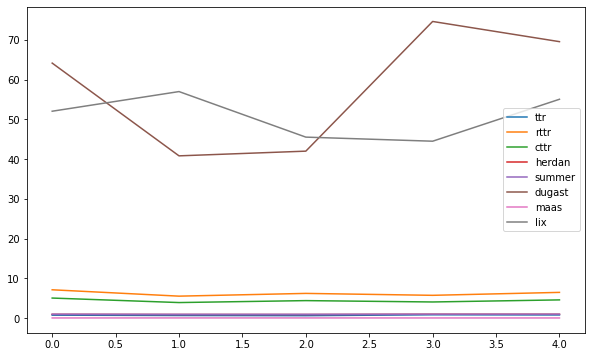

In [12]:
stats = [lexical_diversities(x) for x in train_corpus]

ttr = [x['ttr'] for x in stats]
rttr = [x['rttr'] for x in stats]
cttr = [x['cttr'] for x in stats]
herdan = [x['herdan'] for x in stats]
summer = [x['summer'] for x in stats]
dugast = [x['dugast'] for x in stats]
maas = [x['maas'] for x in stats]
lix = [x['lix'] for x in stats]

fig = plt.figure(figsize=(10,6))
plt.plot(ttr, label='ttr')
plt.plot(rttr, label='rttr')
plt.plot(cttr, label='cttr')
plt.plot(herdan, label='herdan')
plt.plot(summer, label='summer')
plt.plot(dugast, label='dugast')
plt.plot(maas, label='maas')
plt.plot(lix, label='lix')
plt.legend()

# N-Grams
A collection of vectorizers for different types of n-grams.

In [13]:
POS_tagger_DK = spacy.load("da_core_news_md")

OSError: [E050] Can't find model 'da_core_news_md'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
def word_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of word n-grams
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="word", ngram_range=(n,n))
    print(f"Training word {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
    
    return X, vectorizer

def char_ngram_vectorizer(train_corpus, n): 
    #Trains a TF-IDF vectorizer of character n-grams
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="char", ngram_range=(n,n))
    print(f"Training char {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(train_corpus)
    print("Vectorizer fit!", rand_emot())
      
    return X, vectorizer

def extract_POS(corpus):
    POS_corpus = []
    print("Extracting POS...")
    
    for doc in tqdm(corpus):
        tagged_doc = POS_tagger_DK(doc) #tag each document in corpus with POS tags using spacy
        POS_list = []

        for token in tagged_doc:
            POS_list.append(token.pos_)

        #concatenate as POS tags for the document
        POS_text = " ".join(POS_list)
        POS_corpus.append(POS_text)
    return POS_corpus

def POS_ngram_vectorizer(POS_corpus, n): 
    #Trains a TF-IDF vectorizer of POS n-grams. A POS corpus is generated in the function using a tagger for Danish.
   
    vectorizer = TfidfVectorizer(max_features=3000, analyzer="word", ngram_range=(n,n))
    print(f"Training POS {n}-gram vectorizer...",rand_emot())
    
    X = vectorizer.fit_transform(POS_corpus)
    print("Vectorizer fit!", rand_emot())

    return X, vectorizer

In [ ]:
# Gets weights for terms based on trained vectorizer
# Works for both word and character ngrams
def get_tfidf_ngrams(vectorizer, test_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''
    #Multiple texts required
    return vectorizer.transform(test_corpus)

# Function generates POS test corpus first and then gets weights for terms based on trained vectorizer. 
def get_tfidf_POS_ngrams(vectorizer, POS_corpus):
    '''Returns the TF-IDF weighted ngram frequencies of test documents'''    
    #Multiple texts required
    return vectorizer.transform(POS_corpus)

In [ ]:
%%capture
def train_vectorizers(training_data):
    '''Returns 2 dictionaries: vectorizers and weights
    Only use this function on training data'''
    
    X_word_unigrams, unigram_word_vectorizer = word_ngram_vectorizer(training_data, 1)
    X_word_bigrams, bigram_word_vectorizer = word_ngram_vectorizer(training_data, 2)
    X_word_trigrams, trigram_word_vectorizer = word_ngram_vectorizer(training_data, 3)
    
    X_char_unigrams, unigram_char_vectorizer = char_ngram_vectorizer(training_data, 1)
    X_char_bigrams, bigram_char_vectorizer = char_ngram_vectorizer(training_data, 2)
    X_char_trigrams, trigram_char_vectorizer = char_ngram_vectorizer(training_data, 3)
    
    POS_corpus = extract_POS(training_data)
    
    X_POS_unigrams, unigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 1)
    X_POS_bigrams, bigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 2)
    X_POS_trigrams, trigram_POS_vectorizer = POS_ngram_vectorizer(POS_corpus, 3)
    
    
    vectorizers = {
        'uni_word' : unigram_word_vectorizer,
        'bi_word' : bigram_word_vectorizer,
        'tri_word' : trigram_word_vectorizer,
        'uni_char' : unigram_char_vectorizer,
        'bi_char' : bigram_char_vectorizer,
        'tri_char' : trigram_char_vectorizer,
        'uni_pos' : unigram_POS_vectorizer,
        'bi_pos' : bigram_POS_vectorizer,
        'tri_pos' : trigram_POS_vectorizer,
    }
    
    weights = {
        'uni_word' : X_word_unigrams,
        'bi_word' : X_word_bigrams,
        'tri_word' : X_word_trigrams,
        'uni_char' : X_char_unigrams,
        'bi_char' : X_char_bigrams,
        'tri_char' : X_char_trigrams,
        'uni_pos' : X_POS_unigrams,
        'bi_pos' : X_POS_bigrams,
        'tri_pos' : X_POS_trigrams,
    }
    
    return vectorizers, weights

vectorizers, weights = train_vectorizers(train_corpus)

In [ ]:
get_tfidf_names(vectorizers['uni_word'], weights['uni_word'])

### Combining features
Combine the features into one long as fuck vector!

In [ ]:
def vectorize_test_data(vectorizers, test_data):
    '''Returns weighted matrices for test data.'''
    POS_corpus = extract_POS(test_data)
    weights = {}
    for vectorizer in vectorizers:
        if 'pos' in vectorizer:
            weights[vectorizer] = get_tfidf_POS_ngrams(vectorizers[vectorizer], POS_corpus)
        else:
            weights[vectorizer] = get_tfidf_ngrams(vectorizers[vectorizer], test_data)
    return weights

def combine_data(data, train_test, vectorizers=None):
    #Trains vectorizers if training data is specified.
    if train_test == 'train':
        assert vectorizers == None, "Please do not specify vectorizers when training them!"
        print("Training data specified... Training vectorizers!\n")
        vectorizers, weights = train_vectorizers(data)
    elif train_test == 'test':
        assert type(vectorizers) == dict, "Vectorizers need to be in a dict!"
        print("Test data being vectorized...")
        weights = vectorize_test_data(vectorizers, data)
    else:
        print("Please specify type of data!")
        return
    
    feature_indices = []
    
    uni_word = weights['uni_word'].todense()
    bi_word = weights['bi_word'].todense()
    tri_word = weights['tri_word'].todense()
    
    uni_char = weights['uni_char'].todense()
    bi_char = weights['bi_char'].todense()
    tri_char = weights['tri_char'].todense()
    
    uni_pos = weights['uni_pos'].todense()
    bi_pos = weights['bi_pos'].todense()
    tri_pos = weights['tri_pos'].todense()
    
    #Stack ngrams
    word_ngrams = np.hstack((uni_word, bi_word, tri_word))
    char_ngrams = np.hstack((uni_char, bi_char, tri_char))
    pos_ngrams = np.hstack((uni_pos, bi_pos, tri_pos))
    ngrams = np.hstack((word_ngrams, char_ngrams, pos_ngrams))
    print()
    print("N-grams shape:", ngrams.shape) 
    
    #Stack scalar features
    sentence_stats = [list(get_sentence_length_stats(x).values()) for x in data]
    word_stats = [list(get_word_length_stats(x).values()) for x in data]
    lexical_diversity = [list(lexical_diversities(x).values()) for x in data]
    hapax = [[get_num_hapax(x)] for x in data]
    scalars = np.hstack((sentence_stats, word_stats, lexical_diversity,hapax))
    print("Scalars shape:", scalars.shape)
    
    #Add indices to feature names
    [feature_indices.append('uni_word_ngram') for i in range(uni_word.shape[-1])]
    [feature_indices.append('bi_word_ngram') for i in range(bi_word.shape[-1])]
    [feature_indices.append('tri_word_ngram') for i in range(tri_word.shape[-1])]
    [feature_indices.append('uni_char_ngram') for i in range(uni_char.shape[-1])]
    [feature_indices.append('bi_char_ngram') for i in range(bi_char.shape[-1])]
    [feature_indices.append('tri_char_ngram') for i in range(tri_char.shape[-1])]
    [feature_indices.append('uni_pos_ngram') for i in range(uni_pos.shape[-1])]
    [feature_indices.append('bi_pos_ngram') for i in range(bi_pos.shape[-1])]
    [feature_indices.append('tri_pos_ngram') for i in range(tri_pos.shape[-1])]
    
    #Scalar features
    [feature_indices.append(i) for i in get_sentence_length_stats(data[0]).keys()]
    [feature_indices.append(i) for i in get_word_length_stats(data[0]).keys()]
    [feature_indices.append(i) for i in lexical_diversities(data[0]).keys()]
    feature_indices.append('num_hapax')
    
    return np.hstack((ngrams, scalars)), vectorizers, np.array(feature_indices, dtype=str)
    

In [ ]:
matrix, vectorizers, feature_names = combine_data(list(dataframe["Body"])[:10], 'train')

# Extract the features
Extract the features from all the data.

#### Load the data

In [5]:
path = 'data/additional/scraped'
files = os.listdir(path)
dataframes = []
for file in tqdm(files):
    dataframes.append(pd.read_json(path+'/'+file))

dataframe = pd.concat(dataframes)
del dataframe['level_0']
del dataframe['index']

  0%|          | 0/31 [00:00<?, ?it/s]

#### Split into train/test data

In [12]:
%%time
extract = True
bodies = list(dataframe["Body"])
authors = list(dataframe["Byline"])
if extract:

    train_X_text, test_X_text, train_y_text, test_y_text = train_test_split(bodies, authors, test_size=0.2, random_state=42, stratify=authors)

    #Convert names to categories
    le = LabelEncoder()
    train_y = le.fit_transform(train_y_text)
    test_y = le.fit_transform(test_y_text)

    train_X, vectorizers, feature_names = combine_data(train_X_text, 'train')
    test_X, _, _ = combine_data(test_X_text, 'test', vectorizers=vectorizers)
    
    print("Train shape:", train_X.shape)
    print("Test shape:", test_X.shape)

NameError: name 'combine_data' is not defined

In [ ]:
feat_path = 'data/additional/features/'
np.save(feat_path+'trainX.npz', train_X)
np.save(feat_path+'trainY.npz', train_y)
np.save(feat_path+'estnX.npz', test_X)
np.save(feat_path+'testY.npz', test_y)
np.save(feat_path+'feature_names.npz', feature_names)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing

lrg = LogisticRegression(max_iter=100, n_jobs=2)
lrg.fit(train_X, train_y)
f1_score(test_y, lrg.predict(test_X), average='weighted')

In [ ]:
import classifier_unit_test
output = classifier_unit_test.test_classifier(lrg, train_X, test_X, train_y, test_y, give_roc=True, give_importance=True)

In [ ]:
tpr = output['tpr']
fpr = output['fpr']
dum_tpr, dum_fpr = output['dum_tpr'], output['dum_fpr']
plt.plot(fpr,tpr)
plt.plot(dum_fpr, dum_tpr)

In [ ]:
plt.plot(sorted(output['importances_mean'])[::-1][-20:], label="Top 20 features")
plt.plot(sorted(output['importances_mean'])[::-1][:20], label="Bottom 20 features")
plt.legend()

In [ ]:
r = permutation_importance(lrg, test_X, test_y)

In [ ]:
plt.plot(r.importances_mean.argsort())

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(r.importances_mean[i], r.importances_std[i])

## Topic modeling

In [8]:
with open('function_words/funktionsord.txt', 'r', encoding='utf-8') as f:
    stop_words = f.readlines()
    stop_words = [x.replace('\n','') for x in stop_words]

In [21]:
from gensim.corpora import Dictionary

def remove_symbols(text):
    return re.sub('\W+',' ', text)


docs = [remove_symbols(x) for x in tqdm(train_X_text)] # Remove symbols
docs = [split_words(x.lower().strip()) for x in tqdm(docs)] #Word tokenize all text
docs = [[token for token in doc if not token.isnumeric()] for doc in tqdm(docs)] #Remove numbers
docs = [[token for token in doc if len(token)>1] for doc in tqdm(docs)] #Remove words of 1 character
docs = [[token for token in doc if token not in stop_words] for doc in tqdm(docs)] #Filter stop words

  0%|          | 0/60165 [00:00<?, ?it/s]

  0%|          | 0/60165 [00:00<?, ?it/s]

  0%|          | 0/60165 [00:00<?, ?it/s]

  0%|          | 0/60165 [00:00<?, ?it/s]

  0%|          | 0/60165 [00:00<?, ?it/s]

In [22]:
dictionary = Dictionary(docs)
#Remove words that occur in less than 20 documents and more than 10% of all documents
dictionary.filter_extremes(no_below=20, no_above=0.1)
corpus = [dictionary.doc2bow(doc) for doc in tqdm(docs)]
print("Number of unique tokens:", len(dictionary))
print("Number of documents:", len(corpus))

  0%|          | 0/60165 [00:00<?, ?it/s]

Number of unique tokens: 42848
Number of documents: 60165


In [88]:
from gensim.models.ldamulticore import LdaModel
num_topics = 20
chunksize = 1000 #2k
passes = 10 #(epochs)
iterations = 300 #400
eval_every = 2

_ = dictionary[0] #Initializes some values, necessary for model...
id2word = dictionary.id2token
model_name = "Topic_Classifier_2000"
model = LdaModel(corpus=corpus,
                id2word=id2word,
                chunksize=chunksize,
                alpha='auto',
                eta='auto',
                iterations=iterations,
                num_topics=num_topics,
                passes=passes,
                minimum_probability=0.0,
                eval_every=eval_every)

model.show_topic(0)
#model.save('models/'+model_name)

[('kommune', 0.0055371886),
 ('lars', 0.0051649036),
 ('jensen', 0.0050881184),
 ('nielsen', 0.0037897842),
 ('fokus', 0.0034243625),
 ('formand', 0.0033693924),
 ('skabe', 0.003303952),
 ('søren', 0.0032855128),
 ('andersen', 0.0031967617),
 ('job', 0.002974497)]

In [89]:
for index, score in sorted(model[corpus[0]], key=lambda tup: -1*tup[1]):
    print("Score: {}\tTopic ID: {} Topic: {}".format(score, index, model.print_topic(index, 10)))
    print()

Score: 0.3385375142097473	Topic ID: 2 Topic: 0.005*"byen" + 0.005*"kører" + 0.005*"steder" + 0.004*"aarhus" + 0.004*"bilen" + 0.004*"køre" + 0.004*"biler" + 0.004*"bil" + 0.003*"by" + 0.003*"landet"

Score: 0.21846094727516174	Topic ID: 15 Topic: 0.005*"dr" + 0.004*"virkelig" + 0.004*"venner" + 0.003*"historie" + 0.003*"billeder" + 0.003*"bog" + 0.003*"far" + 0.003*"programmet" + 0.003*"serien" + 0.003*"bogen"

Score: 0.17895559966564178	Topic ID: 12 Topic: 0.008*"kvinder" + 0.005*"ja" + 0.005*"mænd" + 0.005*"ofte" + 0.004*"ord" + 0.004*"nej" + 0.004*"slags" + 0.004*"taler" + 0.004*"sidder" + 0.004*"sociale"

Score: 0.0925760567188263	Topic ID: 1 Topic: 0.039*"film" + 0.017*"filmen" + 0.014*"festival" + 0.013*"of" + 0.012*"musik" + 0.012*"album" + 0.012*"publikum" + 0.009*"koncert" + 0.009*"årets" + 0.008*"scenen"

Score: 0.040713272988796234	Topic ID: 19 Topic: 0.017*"sagen" + 0.008*"sag" + 0.008*"bladet" + 0.007*"årig" + 0.006*"mor" + 0.006*"retten" + 0.006*"kvinde" + 0.006*"fortalte

In [90]:
model.show_topic(0)

[('kommune', 0.0055371886),
 ('lars', 0.0051649036),
 ('jensen', 0.0050881184),
 ('nielsen', 0.0037897842),
 ('fokus', 0.0034243625),
 ('formand', 0.0033693924),
 ('skabe', 0.003303952),
 ('søren', 0.0032855128),
 ('andersen', 0.0031967617),
 ('job', 0.002974497)]

In [91]:
def find_topic(article, dictionary, model):
    '''
     For each query ( document in the test file) , tokenize the 
     query, create a feature vector just like how it was done while training
     and create text_corpus
    '''
    doc = remove_symbols(article) # Remove symbols
    doc = split_words(doc.lower().strip()) #Word tokenize all text
    doc = [token for token in doc if not token.isnumeric()] #Remove numbers
    doc = [token for token in doc if len(token)>1] #Remove words of 1 character
    doc = [token for token in doc if token not in stop_words] #Filter stop words
    '''
     For each feature vector text, lda[doc_bow] gives the topic
     distribution, which can be sorted in descending order to print the 
     very first topic
    ''' 
    
    doc_bow = dictionary.doc2bow(doc)
    topics = sorted(model[doc_bow],key=lambda x:x[1],reverse=True)
    return doc_bow, topics

In [120]:
doc_bow, topics = find_topic(t, dictionary, model)
topics

[(15, 0.25037295),
 (7, 0.18012854),
 (13, 0.12205197),
 (2, 0.092404105),
 (14, 0.077307396),
 (0, 0.042756647),
 (12, 0.041925833),
 (17, 0.038911402),
 (5, 0.02867531),
 (19, 0.02499857),
 (6, 0.017926294),
 (9, 0.013499608),
 (10, 0.012602675),
 (3, 0.011902041),
 (1, 0.011248909),
 (18, 0.011109059),
 (8, 0.006846581),
 (11, 0.0059698075),
 (4, 0.0053438563),
 (16, 0.00401841)]

In [121]:
model.show_topic(topics[0][0])

[('dr', 0.0052841823),
 ('virkelig', 0.004220387),
 ('venner', 0.0036632197),
 ('historie', 0.003304305),
 ('billeder', 0.0032600218),
 ('bog', 0.0032504452),
 ('far', 0.0031817912),
 ('programmet', 0.0031117015),
 ('serien', 0.00293375),
 ('bogen', 0.0027776367)]

In [119]:
t = 'pik fuck shit lort fisse crap pis skid røv neger jødesmovs perker kusse smatso kælling skiderik stodder mongol kæft helvede satan fandens'

In [104]:
dataframe[dataframe.Body.str.contains('Forhandlingerne mellem Badminton Danmark og Danske Elitesportsudøveres')]

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
266583,666170,motormagasinet.dk,"Forhandlingerne mellem Badminton Danmark og Danske Elitesportsudøveres Forening (DEF-Sport) er gået i hårdknude, Torsdag meldte Badminton Danmark ud, at de ikke har kunnet blive enige om en ny aftale fra 1. december. Det betyder, at Badminton Danmark har nedlagt elitetræningen fra på mandag, og derfor skal de danske badmintonstjerner selv stå for træningen i diverse sjællandske klubber. - Jeg er selvfølgelig rigtig ærgerlig over, at vi ikke har kunnet blive enige, men jeg er mest ærgerlig over, at Badminton Danmark har truffet den beslutning, som de har, ved at suspendere træningen fra på mandag af. Jeg synes, at forhandlingerne er ganske konstruktive i øjeblikket, siger Hans-Kristian Solberg Vittinghus til Ekstra Bladet. Den 32-årige herresinglespiller mener, at Badminton Danmark i forbindelse med aftalen, der udløber 30. november, er forpligtet til at videreføre de sportslige forhold heriblandt træningen. - Jeg synes egentlig, at det ville give mest mening at fortsætte det gode ...",Udelukket på ubestemt tid: Dansk stjerne forstår ikke beslutning,2009-05-17T00:00:00,https://www.motormagasinet.dk/article/view/468602/delebil_tilbyder_brugere_manedsabonnement,Allan Bauer,1480271848


In [98]:
pd.set_option('display.max_colwidth', 1000)